## Детекция особых точек

Нашей целью будет провести эксперименты для трёх детекторов особых точек и оценить их работу по метрике repeatability, а также по времени работы

In [138]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from os import path, listdir

In [137]:
SAMPLE_IMAGE = path.join("samples", "poem", "01.tif")

IMAGES_DIRPATH = path.join("samples", "poem")

### Используемые алгоритмы

Давайте посмотрим на алгоритмы, которые мы будем тестировать

#### Shi-Tomashi

Детектор угловых точек

In [189]:
def apply_ShiTomashi(filepath: str, points_to_track=100):
    image = cv.imread(filepath)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    corners = cv.goodFeaturesToTrack(gray, points_to_track, 0.01, 10)
    # corners = np.int0(corners)

    descriptors = corners[:, 0, :]

    for i in np.int0(corners):
        x, y = i.ravel()
        cv.circle(image, (x,y), 3, 255, -1)

    result_image = image

    return result_image, corners, descriptors

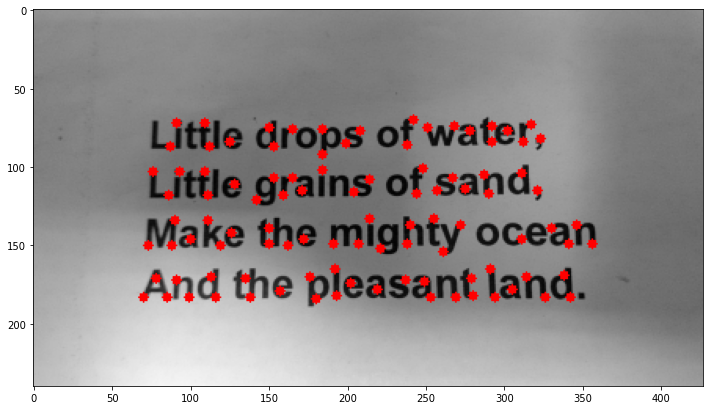

In [190]:
result_image, ShiTomashi_keypoints, ShiTomashi_descriptors = apply_ShiTomashi(SAMPLE_IMAGE)

plt.figure(figsize=(12, 8))
plt.imshow(result_image)
plt.show()

#### SIFT

In [108]:
def apply_SIFT(filepath: str):
    img = cv.imread(filepath)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    sift = cv.SIFT_create()
    kps, descriptors = sift.detectAndCompute(gray, None)

    result_image = cv.drawKeypoints(gray, kps, None, color=(255, 0, 0))

    keypoints = np.int0([kp.pt for kp in kps])

    return result_image, keypoints, descriptors

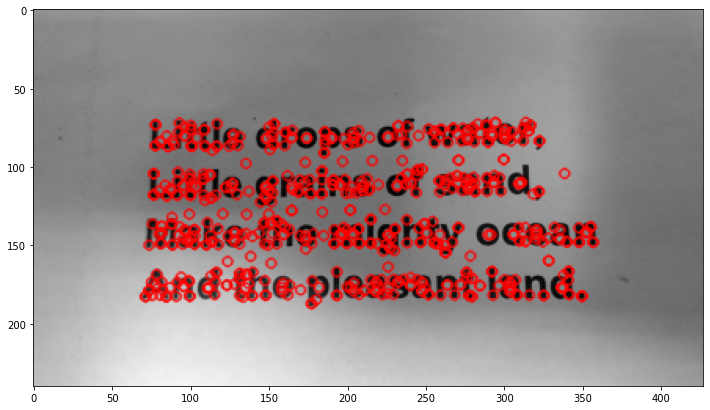

In [110]:
result_image, SIFT_keypoints, SIFT_desriptors = apply_SIFT(SAMPLE_IMAGE)

plt.figure(figsize=(12, 8))
plt.imshow(result_image)
plt.show()

#### ORB

In [114]:
def apply_ORB(filepath: str):
    img = cv.imread(filepath)

    orb = cv.ORB_create()

    kps = orb.detect(img, None)
    kps, descriptors = orb.detectAndCompute(img, None)

    result_image = cv.drawKeypoints(img, kps, None, color=(255, 0, 0))

    keypoints = np.int0([kp.pt for kp in kps])

    return result_image, keypoints, descriptors

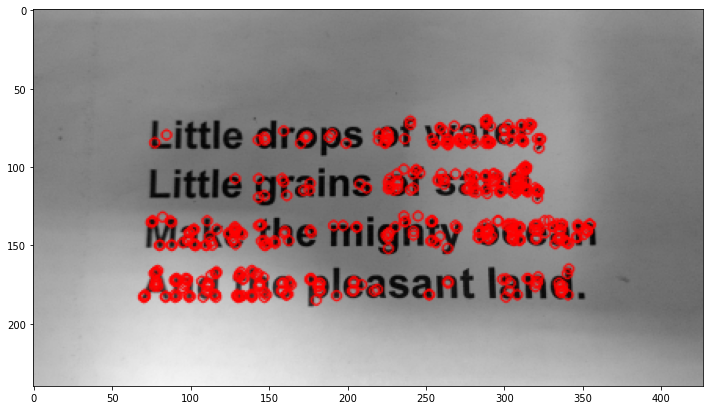

In [115]:
result_image, ORB_keypoints, ORB_descriptors = apply_ORB(SAMPLE_IMAGE)

plt.figure(figsize=(12, 8))
plt.imshow(result_image)
plt.show()

### Matching

Давайте подготовим функцию, с помощью которой будем сопоставлять особые точки

In [159]:
def find_matches(descriptors_1, descriptors_2, norm):
    bf = cv.BFMatcher(norm, crossCheck=True)

    matches = bf.match(descriptors_1, descriptors_2)

    matches = sorted(matches, key = lambda x: x.distance)

    return matches

In [160]:
_, _, desc1 = apply_ORB(SAMPLE_IMAGE)
_, _, desc2 = apply_ORB("samples/poem/02.tif")

len(find_matches(desc1, desc2, cv.NORM_HAMMING))

321

### Repeatability

Напишем функцию для подсчета воспроизводимости

In [161]:
def get_repeatability(all_descriptors, norm):
    # all_descriptors: список дескрипторов всех точек

    # Найдём repeatability для каждой фотографии
    image_repeatability = []

    for i, descriptors_1 in enumerate(all_descriptors):
        # Рассматриваем точки из текущего кадра относительно остальных
        point_occurencies_count = [0 for _ in range(len(descriptors_1))]

        for j, descriptors_2 in enumerate(all_descriptors):
            if i == j:
                continue

            matches = find_matches(descriptors_1, descriptors_2, norm)

            for match in matches:
                point_occurencies_count[match.queryIdx] += 1
    
        # Воспроизводимость точки - доля кадров, в которых она обнаруживается
        frames_count = len(all_descriptors) - 1 # Не считаем текущий кадр
        point_repeatability = [count / frames_count for count in point_occurencies_count]

        # Воспроизводимость детектора - среднее по всем особым точкам
        repeatability = np.mean(point_repeatability)

        image_repeatability.append(repeatability)
    
    return image_repeatability

### Эксперименты

Время во всех экспериментах считается с учётом препроцессинга картинок, то есть считаем, что у нас end2end программа

In [222]:
def display_repeatabilities(repeatabilities, algorithm_name):
    plt.title(f"Воспроизводимость для {algorithm_name}")

    plt.xlabel("Кадр")
    plt.ylabel("Воспроизводимость")

    plt.plot(repeatabilities)

    plt.figure(figsize=(12, 8))
    plt.show()

#### Shi-Tomashi

In [210]:
%%timeit

total_ShiTomashi_keypoints = 0
all_ShiTomashi_descriptors = []
for image_filename in listdir(IMAGES_DIRPATH):
    image_filepath = path.join(IMAGES_DIRPATH, image_filename)

    _, _, ShiTomashi_descriptors = apply_ShiTomashi(image_filepath)

    total_ShiTomashi_keypoints += len(ShiTomashi_descriptors)

    all_ShiTomashi_descriptors.append(ShiTomashi_descriptors)

ShiTomashi_repeatability = get_repeatability(all_ShiTomashi_descriptors, cv.NORM_L2)

36.3 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [235]:
ShiTomashi_time = 36
ShiTomashi_point_time = ShiTomashi_time / total_ShiTomashi_keypoints

print(f"На одну особую точку ушло {ShiTomashi_point_time} милисекунд(-ы)")
print(f"Всего особых точек {total_ShiTomashi_keypoints}")

На одну особую точку ушло 0.03 милисекунд(-ы)
Всего особых точек 1200


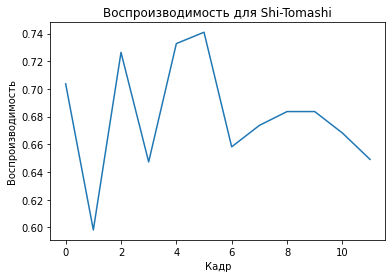

<Figure size 864x576 with 0 Axes>

In [228]:
display_repeatabilities(ShiTomashi_repeatability, "Shi-Tomashi")

#### SIFT

In [213]:
%%timeit

total_SIFT_keypoints = 0
all_SIFT_descriptors = []
for image_filename in listdir(IMAGES_DIRPATH):
    image_filepath = path.join(IMAGES_DIRPATH, image_filename)

    _, _, SIFT_descriptors = apply_SIFT(image_filepath)

    total_SIFT_keypoints += len(SIFT_descriptors)

    all_SIFT_descriptors.append(SIFT_descriptors)

SIFT_repeatability = get_repeatability(all_SIFT_descriptors, cv.NORM_L2)

463 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [234]:
SIFT_time = 463
SIFT_point_time = SIFT_time / total_SIFT_keypoints

print(f"На одну особую точку ушло {SIFT_point_time} милисекунд(-ы)")
print(f"Всего особых точек {total_SIFT_keypoints}")

На одну особую точку ушло 0.06283077758176144 милисекунд(-ы)
Всего особых точек 7369


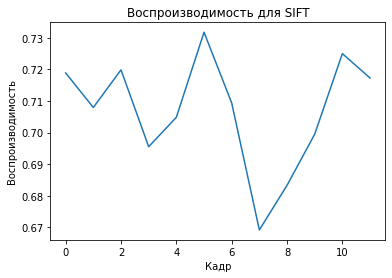

<Figure size 864x576 with 0 Axes>

In [225]:
display_repeatabilities(SIFT_repeatability, "SIFT")

#### ORB

In [216]:
%%timeit

total_ORB_keypoints = 0
all_ORB_descriptors = []
for image_filename in listdir(IMAGES_DIRPATH):
    image_filepath = path.join(IMAGES_DIRPATH, image_filename)

    _, _, ORB_descriptors = apply_ORB(image_filepath)

    total_ORB_keypoints += len(ORB_descriptors)

    all_ORB_descriptors.append(ORB_descriptors)

ORB_repeatability = get_repeatability(all_ORB_descriptors, cv.NORM_HAMMING)

192 ms ± 3.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [233]:
ORB_time = 192
ORB_point_time = ORB_time / total_ORB_keypoints

print(f"На одну особую точку ушло {ORB_point_time} милисекунд(-ы)")
print(f"Всего особых точек {total_ORB_keypoints}")

На одну особую точку ушло 0.033426183844011144 милисекунд(-ы)
Всего особых точек 5744


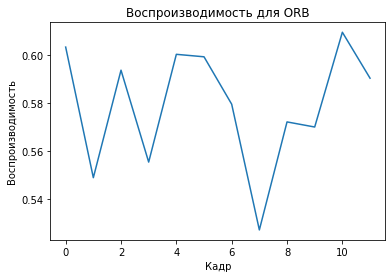

<Figure size 864x576 with 0 Axes>

In [229]:
display_repeatabilities(ORB_repeatability, "ORB")

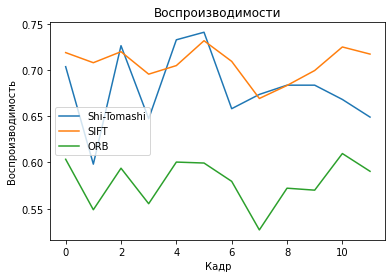

<Figure size 864x576 with 0 Axes>

In [232]:
plt.title(f"Воспроизводимости")

plt.xlabel("Кадр")
plt.ylabel("Воспроизводимость")

plt.plot(ShiTomashi_repeatability)
plt.plot(SIFT_repeatability)
plt.plot(ORB_repeatability)

plt.legend(["Shi-Tomashi", "SIFT", "ORB"])

plt.figure(figsize=(12, 8))
plt.show()

#### Выводы

Из трёх алгоритмов по воспроизводимости хорошие результаты показали Shi-Tomashi и SIFT. 

Стоит учесть важную вещь: первый алгоритм выделил всего 1200 особых точек, а второй -- 7369. То есть он выделяет в изображении больше полезной информации, которая присутствувет и в остальных изображениях.

Что касается времени, SIFT в два раза медленее остальных алгоритмов, но при остальных криериях скоростью вычислений можно пожертвовать.